<a href="https://colab.research.google.com/github/oimartin/MNIST_Digit_Recognizer/blob/main/digits_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

In [2]:
# Install for colab
# !pip install yellowbrick

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, ClassPredictionError
from yellowbrick.style import set_palette

%matplotlib inline

# Data Preprocessing
from sklearn.model_selection import train_test_split

# Models
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from keras.models import Sequential
from keras import layers

# Model Fit Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import silhouette_score

## First View of Digit Data

In [4]:
train = pd.read_csv('https://raw.githubusercontent.com/oimartin/MNIST_Digit_Recognizer/main/data/train.zip')
test = pd.read_csv('https://raw.githubusercontent.com/oimartin/MNIST_Digit_Recognizer/main/data/test.zip')

display(train.shape, test.shape)

(42000, 785)

(28000, 784)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [6]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# EDA

### Explore Label Column

In [7]:
train.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

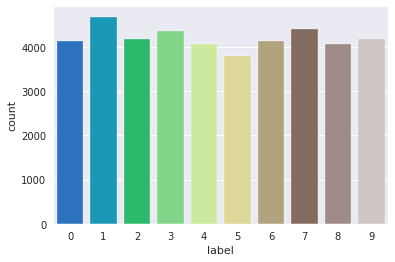

In [8]:
sns.set_style("darkgrid")
sns.countplot(data=train, x='label', palette='terrain')

### Missing Values

In [9]:
def null_sum (df):
  # double check for missing values
  nulls = df.isnull().sum()
  return nulls[nulls >=1]

In [10]:
null_sum(train)

Series([], dtype: int64)

In [11]:
null_sum(test)

Series([], dtype: int64)

## Split Data

In [12]:
def split_data (data_frame):

# Create subset of train data to run faster
# Subset code inspired by Ben Hamner https://www.kaggle.com/benhamner/rf-proximity
  mini_df = data_frame.iloc[:1000, :]
  labels = mini_df.label.astype('category')
  mini_df = mini_df.drop(columns='label')

  X_train, X_test, labels_train, labels_test = train_test_split(mini_df,
                                                                labels,
                                                                test_size=0.2,
                                                                random_state=22)

  print(f'''X_train shape {X_train.shape}
labels_train shape {labels_train.shape}
X_test shape {X_test.shape}
labels_test {labels_test.shape}
''')
  return  X_train, X_test, labels_train, labels_test

In [13]:
X_train, X_test, labels_train, labels_test = split_data(train)

X_train shape (800, 784)
labels_train shape (800,)
X_test shape (200, 784)
labels_test (200,)



# Model

## Model Functions

In [14]:
def run_model (model, model_name, x_data, y_data, gridcv=False,params=None):
  if gridcv is True:
    clf = GridSearchCV(model,params)
    start = time()
    fitted_model = clf.fit(x_data, y_data)
    end = time()
    runtime = round((end - start),4)
    print(f"{model_name} took {runtime} seconds or {round((runtime/60),4)} minutes to run.")

  elif gridcv is False:
    start = time()
    fitted_model = model.fit(x_data, y_data)
    end = time()
    runtime = round((end-start), 4)
    print(f"{model_name} took {runtime} seconds or {round((runtime/60),4)} minutes to run.")
  return fitted_model, runtime

def prediction (fitted_model, x_feat, deep=False):
  pred = fitted_model.predict(x_feat)

  if deep is True:
    pred = np.argmax(pred, axis=-1)

  return pred

def probability (fitted_model, x_feat):
  total_prob = fitted_model.predict_proba(x_feat)
  return total_prob

def evaluating_model (y_true, y_pred, model_name, train_test, runtime):
  df=pd.DataFrame({ 'model_name': [model_name, model_name, 
                                   model_name, model_name,
                                   model_name],
                   'type': [train_test, train_test,
                            train_test, train_test,
                            train_test],
                   'metric_name': ["accuracy","f1",'recall',
                                   'precision', 'runtime_min'],
                   'metric' : [round(accuracy_score(y_true, y_pred),4),
                               round(f1_score(y_true, y_pred, average='micro'),4),
                               round(recall_score(y_true, y_pred, average='micro'), 4),
                               round(precision_score(y_true, y_pred, average='micro'), 4),
                               round((runtime/60),4)]})
  display(df)
  return df

def prob_eval (y_true, y_prob, model_name, train_test):
  df=pd.DataFrame({ 'model_name': [model_name, model_name],
                   'type': [train_test, train_test],
                   'metric_name': ['log_loss','roc_auc'],
                   'metric' : [round(log_loss(y_true, y_prob), 4),
                               round(roc_auc_score(y_true, y_prob, multi_class='ovo'),4)]})
  display(df)
  return df


def eval_classification (y_pred, y_true, x_data, model_name, train_test):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
  print(f'''
  {model_name} for {train_test} Data
  FPR {fpr}
  TPR {tpr}
  ''')
  return

def class_vis (model, model_name, x_train, y_train, x_test, y_test):
  sns.set_style("darkgrid")
  set_palette('paired')
  visualizer = ClassificationReport(model, classes=list(y_train.unique()), support=True)
  visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
  visualizer.score(x_test, y_test)        # Evaluate the model on the test data
  visualizer.show(outpath=f"{model_name}_classification_report.png")
  visualizer.show()

  cm = ConfusionMatrix(model, classes=list(y_train.unique()))
  cm.fit(x_train, y_train)
  cm.score(x_test, y_test)
  cm.show(outpath=f"{model_name}_confusin_matrix.png")
  cm.show()

  vis = ROCAUC(model, classes=list(y_train.unique()))
  vis.fit(x_train, y_train)
  vis.score(x_test, y_test)
  vis.show(outpath=f"{model_name}_rocauc.png")
  vis.show()

  graph = ClassPredictionError(model, classes=list(y_train.unique()))
  graph.fit(x_train, y_train)
  graph.score(x_test, y_test)
  graph.show(outpath=f"{model_name}_class_prediction.png")
  graph.show()
  return

def feature_importance (x_data, model):
  df = pd.DataFrame({'feature': x_data.columns, 'feature_importances': model.feature_importances_}).sort_values(by='feature_importances', ascending=False).head(10)
  return df

def submitted (fitted_model, model_name, test=test):
  pred = fitted_model.predict(test)
  df = pd.DataFrame(pred).rename(columns={0: 'Label'}).astype('int64')
  df.index += 1
  df['ImageId'] = df.index
  df.to_csv(f"{model_name}_pred.csv", index=False) 
  return df


## Random Forest Classifier

In [31]:
RFC_model, RFC_rt = run_model(RandomForestClassifier(random_state=22), 'RFC', 
                              X_train, labels_train, False)

train_pred_RFC = prediction(RFC_model, X_train)
train_totprob_RFC = probability(RFC_model, X_train)

test_pred_RFC = prediction(RFC_model, X_test)
test_totprob_RFC = probability(RFC_model, X_test)

RFC took 0.4911 seconds or 0.0082 minutes to run.


### RFC Evaluation

In [33]:
RFC_train = evaluating_model(labels_train, train_pred_RFC, 'RFC', 'Train', RFC_rt)
RFC_train_prob = prob_eval(labels_train, train_totprob_RFC, 'RFC', 'Train')
eval_classification(train_pred_RFC, labels_train, X_train, 'RFC', 'Train')

print("---------------------")
RFC_test = evaluating_model(labels_test, test_pred_RFC, 'RFC', 'Test', RFC_rt)
RFC_test_prob = prob_eval(labels_test, test_totprob_RFC, 'RFC', 'Test')
eval_classification(test_pred_RFC, labels_test, X_test, 'RFC', 'Test')

,model_name,type,metric_name,metric
0,RFC,Train,accuracy,1.0000
1,RFC,Train,f1,1.0000
2,RFC,Train,recall,1.0000
3,RFC,Train,precision,1.0000
4,RFC,Train,runtime_min,0.0082


,model_name,type,metric_name,metric
0,RFC,Train,log_loss,0.192
1,RFC,Train,roc_auc,1.000



  RFC for Train Data
  FPR [0.         0.11080332 0.20775623 0.32409972 0.43351801 0.53739612
 0.6468144  0.74792244 0.88642659 0.88642659 1.        ]
  TPR [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
  
---------------------


,model_name,type,metric_name,metric
0,RFC,Test,accuracy,0.9050
1,RFC,Test,f1,0.9050
2,RFC,Test,recall,0.9050
3,RFC,Test,precision,0.9050
4,RFC,Test,runtime_min,0.0082


,model_name,type,metric_name,metric
0,RFC,Test,log_loss,0.7283
1,RFC,Test,roc_auc,0.9891



  RFC for Test Data
  FPR [0.         0.09340659 0.20879121 0.31318681 0.3956044  0.46153846
 0.5989011  0.71428571 0.84615385 0.85714286 1.        ]
  TPR [0.         0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 1.         1.        ]
  


In [ ]:
feature_importance(X_train, RFC_model)

In [ ]:
class_vis(RFC_model, 'RFC', X_train, labels_train, 
             X_test, labels_test)

### Actual Test Data Predictions

In [ ]:
submitted(RFC_model, 'RFC')

## RFC with GridCV

### Run Model

In [34]:
parameters = {'n_estimators':[100,200,400],
              'criterion': ('gini', 'entropy'),
              'min_samples_split': [2,3,4],
              'min_samples_leaf': [1,2,3],
              'random_state': [22]}

RFCcv_model, RFCcv_rt = run_model(RandomForestClassifier(),'RFCcv',
                                  X_train,
                                  labels_train, 
                                  True,
                                  parameters)

train_pred_RFCcv = prediction(RFCcv_model, X_train)
train_totprob_RFCcv = probability(RFCcv_model, X_train)

test_pred_RFCcv = prediction(RFCcv_model, X_test)
test_totprob_RFCcv = probability(RFCcv_model, X_test)

RFCcv took 348.4744 seconds or 5.8079 minutes to run.


In [35]:
RFCcv_model.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 200,
 'random_state': 22}

### RFC with GridCV Evaluation

In [36]:
RFCcv_train = evaluating_model(labels_train, train_pred_RFCcv, 'RFCcv', 'Train', RFCcv_rt)
RFCcv_train_prob = prob_eval(labels_train, train_totprob_RFCcv, 'RFCcv', 'Train')
eval_classification(train_pred_RFCcv, labels_train, X_train, 'RFCcv', 'Train')

print("---------------------")
RFCcv_test = evaluating_model(labels_test, test_pred_RFCcv, 'RFCcv', 'Test')
RFCcv_test_prob = prob_eval(labels_test, test_totprob_RFCcv, 'RFCcv', 'Test')
eval_classification(test_pred_RFCcv, labels_test, X_test, 'RFCcv', 'Test')

,model_name,type,metric_name,metric
0,RFCcv,Train,accuracy,1.0000
1,RFCcv,Train,f1,1.0000
2,RFCcv,Train,recall,1.0000
3,RFCcv,Train,precision,1.0000
4,RFCcv,Train,runtime_min,5.8079


,model_name,type,metric_name,metric
0,RFCcv,Train,log_loss,0.227
1,RFCcv,Train,roc_auc,1.000



  RFCcv for Train Data
  FPR [0.         0.11080332 0.20775623 0.32409972 0.43351801 0.53739612
 0.6468144  0.74792244 0.88642659 0.88642659 1.        ]
  TPR [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
  
---------------------


TypeError: ignored

In [ ]:
class_vis(RFCcv_model, 'RFCcv', X_train, labels_train, 
             X_test, labels_test)

### Actual Test Data Predictions

In [ ]:
submitted(RFCcv_model, 'RFCcv')

## Principal Component Analysis

In [ ]:
def components_time (model):
    start = time()
    comps = model.components_
    end = time()
    runtime = round((end - start),4)
    print(f"Number of PCA components {len(comps)}, completed in {runtime} seconds or {round((runtime/60),4)} minutes to run.")
    return comps

In [ ]:
data = pd.concat([train,test])
data.shape

(70000, 785)

In [ ]:
X_train, X_test, labels_train, labels_test = split_data(data)

X_train shape (800, 784)
labels_train shape (800,)
X_test shape (200, 784)
labels_test (200,)



### Run PCA

In [ ]:
PCA_model, PCA_rt = run_model(PCA(n_components=0.95, svd_solver='full'), 'PCA', X_train, labels_train, gridcv=False)
PCA_comps = components_time(PCA_model)

PCA took 0.2644 seconds or 0.0044 minutes to run.
Number of PCA components 127, completed in 0.0 seconds or 0.0 minutes to run.


In [ ]:
X_train_PCA = PCA_model.transform(X_train)
X_test_PCA = PCA_model.transform(X_test)
test_PCA = PCA_model.transform(test)

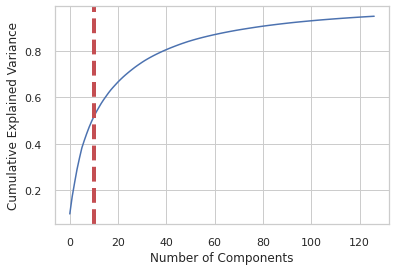

None

,Cumulative Variance Ratio,Explained Variance Ratio
122,0.947688,0.000642
123,0.948321,0.000632
124,0.948944,0.000623
125,0.949555,0.000611
126,0.950158,0.000603


<Figure size 432x288 with 0 Axes>

In [ ]:
sns.set(style='whitegrid')

plt.plot(np.cumsum(PCA_model.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())

evr = PCA_model.explained_variance_ratio_
cvr = np.cumsum(PCA_model.explained_variance_ratio_)

pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.tail())
plt.savefig("no_components_cumul_expl_var.png")

## Random Forest Classifier with PCA Components

In [ ]:
RFC_PCA_model, RFC_PCA_rt = run_model(RandomForestClassifier(), 'RFC_PCA', X_train_PCA, labels_train, False)
train_pred_RFC_PCA = prediction(RFC_PCA_model, X_train_PCA)
train_totprob_RFC_PCA = probability(RFC_PCA_model, X_train_PCA)

test_pred_RFC_PCA = prediction(RFC_PCA_model, X_test_PCA)
test_totprob_RFC_PCA = probability(RFC_PCA_model, X_test_PCA)

RFC_PCA took 0.631 seconds or 0.0105 minutes to run.


### RFC with PCA Evaluation

In [ ]:
RFC_PCA_train = evaluating_model(labels_train, train_pred_RFC_PCA, 'RFC_PCA', 'Train', RFC_PCA_rt)
RFC_PCA_train_prob = prob_eval(labels_train, train_totprob_RFC_PCA, 'RFC_PCA', 'Train')
eval_classification(train_pred_RFC_PCA, labels_train, X_train_PCA, 'RFC_PCA', 'Train')

print("---------------------")
RFC_PCA_test = evaluating_model(labels_test, test_pred_RFC_PCA, 'RFC_PCA', 'Test')
RFC_PCA_test_prob = prob_eval(labels_test, test_totprob_RFC_PCA, 'RFC_PCA', 'Test')
eval_classification(test_pred_RFC, labels_test, X_test_PCA, 'RFC_PCA', 'Test')

,model_name,type,metric_name,metric
0,RFC_PCA,Train,accuracy,1.0
1,RFC_PCA,Train,f1,1.0
2,RFC_PCA,Train,recall,1.0
3,RFC_PCA,Train,precision,1.0


,model_name,type,metric_name,metric
0,RFC_PCA,Train,log_loss,0.2776
1,RFC_PCA,Train,roc_auc,1.0000



  RFC_PCA for Train Data
  FPR [0.         0.11080332 0.20775623 0.32409972 0.43351801 0.53739612
 0.6468144  0.74792244 0.88642659 0.88642659 1.        ]
  TPR [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
  
---------------------


,model_name,type,metric_name,metric
0,RFC_PCA,Test,accuracy,0.845
1,RFC_PCA,Test,f1,0.845
2,RFC_PCA,Test,recall,0.845
3,RFC_PCA,Test,precision,0.845


,model_name,type,metric_name,metric
0,RFC_PCA,Test,log_loss,1.1266
1,RFC_PCA,Test,roc_auc,0.9717



  RFC_PCA for Test Data
  FPR [0.         0.09340659 0.20879121 0.31318681 0.3956044  0.46153846
 0.5989011  0.71428571 0.84615385 0.85714286 1.        ]
  TPR [0.         0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 1.         1.        ]
  


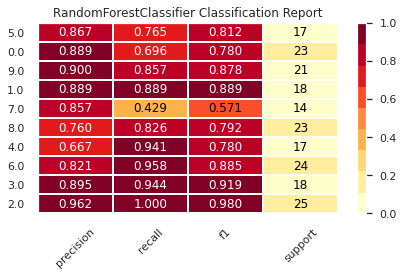

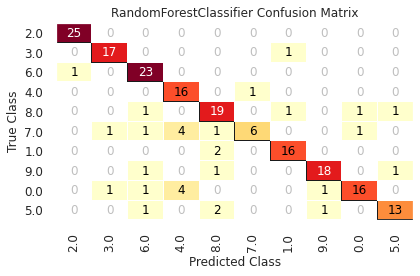

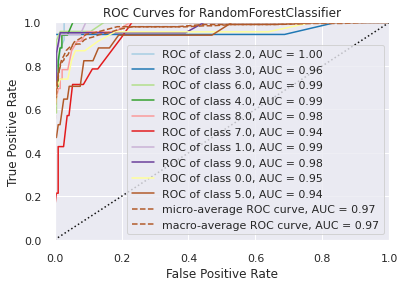

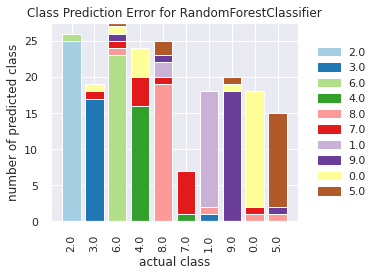

In [ ]:
class_vis(RFC_PCA_model, 'RFC_PCA', X_train_PCA, labels_train, 
             X_test_PCA, labels_test)

### Actual Test Data Predictions

In [ ]:
submitted(RFC_PCA_model, 'RFC_PCA', test_PCA)

,Label,ImageId
1,2,1
2,0,2
3,9,3
4,4,4
5,2,5
...,...,...
27996,9,27996
27997,7,27997
27998,3,27998
27999,9,27999


## K Means Clustering - 10 Clusters

In [ ]:
n_digits = len(np.unique(labels_train))
print(f"Unique digits in labels {n_digits}")

Kmeans_model, Kmeans_rt = run_model(MiniBatchKMeans(n_clusters=n_digits),
                                    'Kmeans', X_train, labels_train, False)
train_pred_Kmeans = prediction(Kmeans_model, X_train)
test_pred_Kmeans = prediction(Kmeans_model, X_test)

Unique digits in labels 10
Kmeans took 0.3493 seconds or 0.0058 minutes to run.


### Kmeans Evaluation

In [ ]:
Kmeans_train = evaluating_model(labels_train, train_pred_Kmeans, 'Kmeans', 'Train')
eval_classification(train_pred_Kmeans, labels_train, X_train, 'Kmeans', 'Train')

print("---------------------")
Kmeans_test = evaluating_model(labels_test, test_pred_Kmeans, 'Kmeans', 'Test')
eval_classification(test_pred_Kmeans, labels_test, X_test, 'Kmeans', 'Test')

,model_name,type,metric_name,metric
0,Kmeans,Train,accuracy,0.175
1,Kmeans,Train,f1,0.175
2,Kmeans,Train,recall,0.175
3,Kmeans,Train,precision,0.175



  Kmeans for Train Data
  FPR [0.         0.07479224 0.14265928 0.33379501 0.43213296 0.53047091
 0.58587258 0.71745152 0.78393352 0.86980609 1.        ]
  TPR [0.         0.         0.         0.01282051 0.01282051 0.02564103
 0.02564103 0.02564103 0.98717949 0.98717949 1.        ]
  
---------------------


,model_name,type,metric_name,metric
0,Kmeans,Test,accuracy,0.17
1,Kmeans,Test,f1,0.17
2,Kmeans,Test,recall,0.17
3,Kmeans,Test,precision,0.17



  Kmeans for Test Data
  FPR [0.         0.06043956 0.12087912 0.28021978 0.37362637 0.46703297
 0.53296703 0.6978022  0.78571429 0.85714286 1.        ]
  TPR [0.         0.         0.         0.         0.05555556 0.05555556
 0.05555556 0.05555556 1.         1.         1.        ]
  


### Actual Test Data Predictions

In [ ]:
submitted(Kmeans_model, 'Kmeans', test)

,Label,ImageId
1,9,1
2,8,2
3,2,3
4,3,4
5,0,5
...,...,...
27996,7,27996
27997,7,27997
27998,0,27998
27999,7,27999


## K Means Clustering with Grid CV

In [23]:
parameters = {'n_clusters': [50, 100, 150, 200],
              'init': ['k-means++', 'random'],
              'max_iter': [100,150],
              'max_no_improvement': [10, 50],
              'random_state': [22]}
Kmeans_cv_model, Kmeans_cv_rt = run_model(MiniBatchKMeans(), 'Kmeans_cv',
                                       X_train, labels_train, True, parameters)
train_pred_Kmeans_cv = prediction(Kmeans_cv_model, X_train)
test_pred_Kmeans_cv = prediction(Kmeans_cv_model, X_test)

Kmeans_cv took 145.4532 seconds or 2.4242 minutes to run.


In [24]:
Kmeans_cv_model.best_params_

{'init': 'random',
 'max_iter': 100,
 'max_no_improvement': 50,
 'n_clusters': 200,
 'random_state': 22}

### Kmeans Evaluation

In [25]:
Kmeans_cv_train = evaluating_model(labels_train, train_pred_Kmeans_cv, 'Kmeans_cv', 'Train', Kmeans_cv_rt)
eval_classification(train_pred_Kmeans_cv, labels_train, X_train, 'Kmeans_cv', 'Train')

print("---------------------")
Kmeans_cv_test = evaluating_model(labels_test, test_pred_Kmeans_cv, 'Kmeans_cv', 'Test',Kmeans_cv_rt)
eval_classification(test_pred_Kmeans_cv, labels_test, X_test, 'Kmeans_cv', 'Test')

,model_name,type,metric_name,metric
0,Kmeans_cv,Train,accuracy,0.0025
1,Kmeans_cv,Train,f1,0.0025
2,Kmeans_cv,Train,recall,0.0025
3,Kmeans_cv,Train,precision,0.0025
4,Kmeans_cv,Train,runtime_min,2.4242



  Kmeans_cv for Train Data
  FPR [0.         0.00138504 0.00138504 0.00969529 0.03047091 0.033241
 0.03739612 0.04847645 0.0567867  0.06094183 0.06094183 0.06094183
 0.06232687 0.06509695 0.0734072  0.07894737 0.09695291 0.10249307
 0.1066482  0.11634349 0.11772853 0.12742382 0.13850416 0.14542936
 0.15373961 0.16897507 0.17313019 0.17451524 0.18559557 0.19390582
 0.20637119 0.2132964  0.21606648 0.22299169 0.22576177 0.22576177
 0.23130194 0.23268698 0.24099723 0.24376731 0.24376731 0.2465374
 0.26177285 0.27146814 0.27423823 0.27423823 0.28531856 0.29778393
 0.30055402 0.30470914 0.30609418 0.31578947 0.3199446  0.33102493
 0.34487535 0.35595568 0.35872576 0.36842105 0.38227147 0.38365651
 0.38642659 0.39750693 0.40027701 0.40858726 0.41135734 0.41689751
 0.42936288 0.43213296 0.44598338 0.44736842 0.45290859 0.45429363
 0.46121884 0.47091413 0.48476454 0.49030471 0.5        0.51108033
 0.52354571 0.52631579 0.53739612 0.54570637 0.54570637 0.55124654
 0.55124654 0.55124654 0.555401

,model_name,type,metric_name,metric
0,Kmeans_cv,Test,accuracy,0.0000
1,Kmeans_cv,Test,f1,0.0000
2,Kmeans_cv,Test,recall,0.0000
3,Kmeans_cv,Test,precision,0.0000
4,Kmeans_cv,Test,runtime_min,2.4242



  Kmeans_cv for Test Data
  FPR [0.         0.00549451 0.04395604 0.05494505 0.06593407 0.07692308
 0.09340659 0.11538462 0.13186813 0.16483516 0.17582418 0.19230769
 0.2032967  0.21428571 0.23626374 0.24725275 0.26373626 0.26923077
 0.26923077 0.28571429 0.2967033  0.31868132 0.32417582 0.34615385
 0.35714286 0.37362637 0.3956044  0.41758242 0.42307692 0.45054945
 0.48351648 0.51098901 0.53296703 0.53846154 0.56043956 0.6043956
 0.6043956  0.6043956  0.62087912 0.64285714 0.64835165 0.64835165
 0.65384615 0.65384615 0.65384615 0.67032967 0.68681319 0.71978022
 0.72527473 0.74175824 0.74725275 0.74725275 0.75274725 0.75274725
 0.76923077 0.78021978 0.78021978 0.7967033  0.80769231 0.82417582
 0.83516484 0.84065934 0.85714286 0.86813187 0.87912088 0.9010989
 0.9010989  0.93406593 0.95054945 0.96153846 0.98351648 0.99450549
 1.        ]
  TPR [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.   

### Actual Test Data Predictions

In [27]:
submitted(Kmeans_cv_model, 'Kmeans_cv', test)

,Label,ImageId
1,178,1
2,167,2
3,196,3
4,192,4
5,11,5
...,...,...
27996,119,27996
27997,117,27997
27998,42,27998
27999,179,27999


## Neural Network

In [15]:
# Inspired by Poonam Ligade: https://www.kaggle.com/poonaml/deep-neural-network-keras-way
def array_reshape2x (data, int_float, data_name, input=None):
  initial_array = data.values.astype(int_float)
  print(f'''-----------------------------------------
{data_name} initial shape {initial_array.shape}''')

  if input is True:
    reshape_1 = initial_array.reshape(initial_array.shape[0], 28, 28)
    reshape_2 = reshape_1.reshape(reshape_1.shape[0], 28, 28, 1)
    
    print(f'''Check first reshape {reshape_1.shape}
Check second reshape{reshape_2.shape}''')
    return initial_array, reshape_1, reshape_2
  else:
    return initial_array

def plot_image (x_data, y_data, title):
  plt.figure(figsize=(6,6))
  for i in range(0,9):
    plt.subplot(330 + (i+1))
    plt.imshow(x_data[i], cmap=plt.get_cmap('gray'))
    plt.title(y_data[i])
  plt.text(-45,-75, title, fontsize='x-large')


-----------------------------------------
X_train array initial shape (800, 784)
Check first reshape (800, 28, 28)
Check second reshape(800, 28, 28, 1)
-----------------------------------------
labels_train array initial shape (800,)


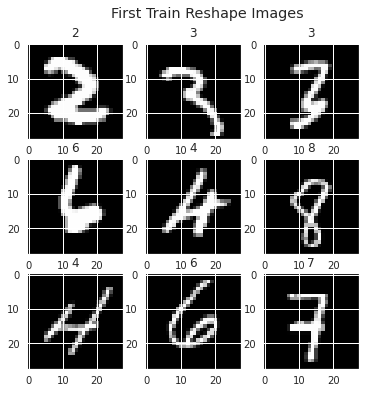

In [16]:
X_train_nn, X_train_nn1, X_train_nn2 = array_reshape2x(X_train, 'float32', 'X_train array', True)
labels_train_nn = array_reshape2x(labels_train, 'int32', 'labels_train array')

plot_image(X_train_nn1, labels_train_nn, 'First Train Reshape Images')

-----------------------------------------
X_train test initial shape (200, 784)
Check first reshape (200, 28, 28)
Check second reshape(200, 28, 28, 1)
-----------------------------------------
labels_test array initial shape (200,)


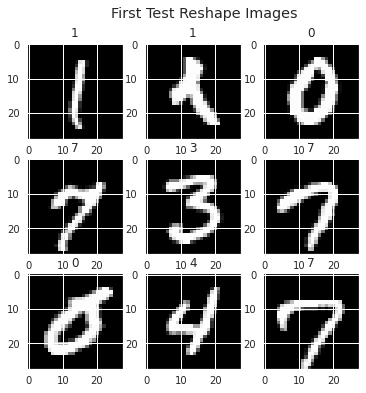

In [17]:
X_test_nn, X_test_nn1, X_test_nn2 = array_reshape2x(X_test, 'float32', 'X_train test', True)
labels_test_nn = array_reshape2x(labels_test, 'int32', 'labels_test array')

plot_image(X_test_nn1, labels_test_nn, 'First Test Reshape Images')

## Sequential - 4 layers, 200 nodes

In [18]:
def run_deep (model, model_name, x_data, y_data):
  start = time()
  model.fit(x_data, y_data)
  end = time()
  runtime = round((end - start),4)
  print(f"{model_name} took {runtime} seconds or {round((runtime/60),4)} minutes to run.")
  return runtime

In [19]:
# Inspired by Poonam Ligade: https://www.kaggle.com/poonaml/deep-neural-network-keras-way
seed = 22
np.random.seed(seed)

In [27]:
layers3_200 = Sequential([
    layers.Dense(150, activation="relu", input_shape=(28,28,1)),
    layers.GaussianNoise(stddev=0.5, seed=22),
    layers.Flatten(),
    layers.Dense(50, activation="softmax")
])
layers3_200.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [28]:
layers3_200rt = run_deep(layers3_200, 'layers3_200', X_train_nn2, labels_train_nn)
train_pred_layers3_200 = prediction(layers3_200, X_train_nn2, True)
test_pred_layers3_200 = prediction(layers3_200, X_test_nn2, True)

25/25 [==============================] - 6s 222ms/step - loss: 40.7375 - accuracy: 0.5800
layers3_200 took 11.0446 seconds or 0.1841 minutes to run.


In [29]:
test_pred_layers3_200

array([1, 5, 5, 7, 3, 7, 5, 4, 7, 4, 3, 2, 0, 5, 3, 2, 8, 7, 4, 4, 7, 2,
       9, 2, 5, 6, 8, 8, 3, 8, 7, 6, 9, 1, 2, 6, 0, 4, 0, 7, 9, 9, 3, 4,
       9, 3, 2, 0, 3, 9, 2, 1, 6, 8, 8, 0, 8, 0, 1, 4, 1, 9, 7, 5, 9, 2,
       4, 2, 7, 1, 4, 5, 7, 9, 8, 4, 1, 8, 3, 3, 7, 0, 6, 2, 7, 1, 0, 3,
       5, 3, 4, 9, 4, 2, 0, 3, 4, 2, 1, 0, 8, 2, 9, 8, 9, 6, 5, 2, 0, 5,
       1, 6, 0, 8, 3, 8, 2, 1, 0, 9, 6, 1, 3, 7, 2, 4, 0, 2, 5, 5, 7, 9,
       3, 7, 6, 6, 3, 1, 4, 8, 3, 0, 8, 2, 1, 9, 9, 0, 0, 3, 9, 5, 8, 5,
       9, 6, 9, 3, 1, 3, 5, 1, 1, 9, 3, 7, 6, 4, 7, 4, 4, 9, 8, 9, 4, 1,
       8, 8, 6, 8, 2, 1, 0, 3, 6, 6, 8, 5, 8, 4, 9, 2, 2, 5, 8, 3, 2, 4,
       2, 2])

### Eval Seq. 4 layers, 200 nodes

In [30]:
layers3_200_train = evaluating_model(labels_train, train_pred_layers3_200, 'layers3_200', 'Train', layers3_200rt)
eval_classification(train_pred_layers3_200, labels_train, X_train, 'layers3_200', 'Train')

print("---------------------")
layers3_200_test = evaluating_model(labels_test, test_pred_layers3_200, 'layers3_200', 'Test',layers3_200rt)
eval_classification(test_pred_layers3_200, labels_test, X_test, 'layers3_200', 'Test')

,model_name,type,metric_name,metric
0,layers3_200,Train,accuracy,0.8612
1,layers3_200,Train,f1,0.8612
2,layers3_200,Train,recall,0.8612
3,layers3_200,Train,precision,0.8612
4,layers3_200,Train,runtime_min,0.1841



  layers3_200 for Train Data
  FPR [0.         0.13019391 0.23130194 0.33518006 0.44044321 0.55955679
 0.65512465 0.77423823 0.8933518  0.90443213 1.        ]
  TPR [0.         0.         0.01282051 0.01282051 0.02564103 0.02564103
 0.02564103 0.02564103 0.03846154 1.         1.        ]
  
---------------------


,model_name,type,metric_name,metric
0,layers3_200,Test,accuracy,0.8100
1,layers3_200,Test,f1,0.8100
2,layers3_200,Test,recall,0.8100
3,layers3_200,Test,precision,0.8100
4,layers3_200,Test,runtime_min,0.1841



  layers3_200 for Test Data
  FPR [0.         0.12637363 0.25274725 0.34615385 0.42857143 0.51648352
 0.63186813 0.75824176 0.89010989 0.9010989  1.        ]
  TPR [0.         0.         0.         0.         0.         0.05555556
 0.05555556 0.05555556 0.05555556 1.         1.        ]
  


# Compare Models

In [19]:
def model_comparisons (df, metric, axis):
  grouped_df = model_compare[model_compare['metric_name'] == metric]

  sns.set_style("darkgrid")
  g = sns.barplot(data=grouped_df, hue='type', x='model_name', y='metric', palette='dark', ax=axis)
  g.set_ylabel(metric)
  g.set_title(f'{metric} of Models \nfor Company Bankruptcy')
  g.legend(loc=(0.6,1.15))

  return

In [20]:
model_compare = pd.concat([RFC_train, RFC_test, RFCcv_train, RFCcv_test,
                           RFC_PCA_train, RFC_PCA_test, Kmeans_train, Kmeans_test,
                           RFC_train_prob, RFC_test_prob, RFC_PCA_test_prob,
                           RFC_PCA_train_prob, RFCcv_test, RFCcv_train, RFCcv_test_prob,
                           RFCcv_train_prob])

NameError: ignored

NameError: ignored

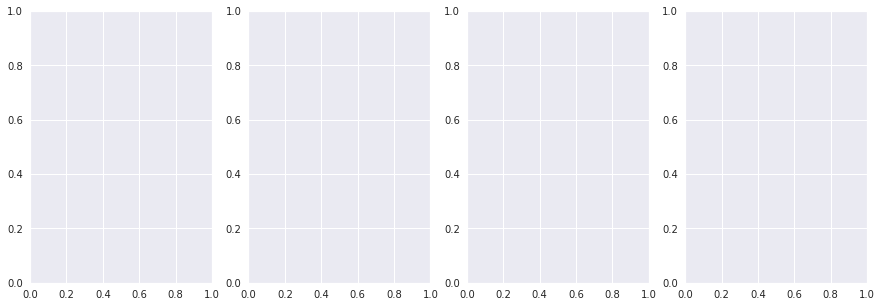

In [30]:
f, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(15,5))

model_comparisons(model_compare, 'accuracy', ax0)
model_comparisons(model_compare, 'f1', ax1)
model_comparisons(model_compare, 'recall', ax2)
model_comparisons(model_compare, 'precision', ax3)

f.savefig('accuracy_f1_recall_precision_digits.png')

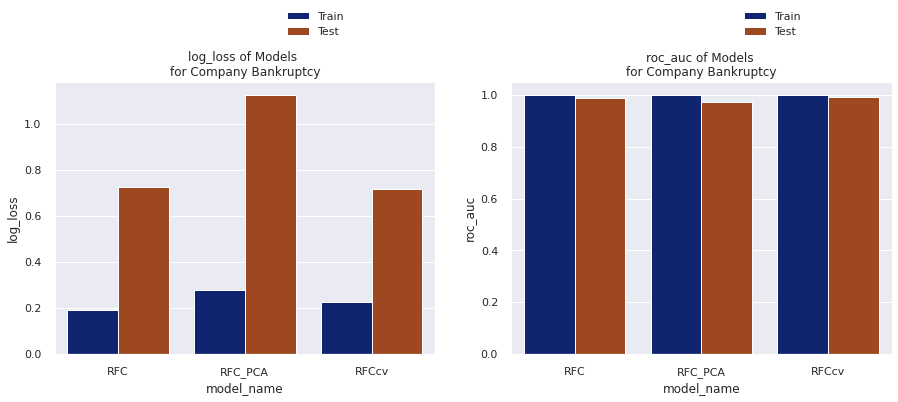

In [ ]:
f, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(15,5))

model_comparisons(model_compare, 'log_loss', ax0)
model_comparisons(model_compare, 'roc_auc', ax1)
model_comparisons(model_compare, 'runtime_min', ax2)

f.savefig('log_loss__roc_auc_runtime_min_digits.png')